In [1]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import data_manager.utils as sbtu
import data_manager.scanner as scanner
import regime as sur
import scripts
# import src.floor_ceiling_regime

In [2]:
(
    _price_data,
    _bench,
    _strategy_overview,
    _peak_table,
    _entry_table,
    _strategy_lookup
) = scripts.load_data_package()
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()


symbol = 'AAPL'
_symbol_data = _price_data_by_symbol.data[symbol]

In [3]:
_prev_exits = _entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1])
].copy()
_prev_exits['sig_len'] = (_prev_exits.exit_signal_date - _prev_exits.entry)
_prev_exits['partial_sig_len'] = (_prev_exits.partial_exit_date - _prev_exits.entry)

In [4]:
sw = _peak_table.loc[(_peak_table.lvl == 2)].copy()
sw['sw_px_gap'] = (sw.en_px.shift(1) - sw.en_px) * sw.type
sw.loc[sw.symbol != sw.symbol.shift(1), 'sw_px_gap'] = np.nan
c = sw.sw_px_gap.loc[sw.sw_px_gap < 0].count()
win_rate = c / len(sw.loc[sw.sw_px_gap.notna()])
avg_win = sw.sw_px_gap.loc[sw.sw_px_gap < 0].sum() / len(sw.loc[sw.sw_px_gap.notna()]) * -1
avg_loss = sw.sw_px_gap.loc[sw.sw_px_gap > 0].sum() / len(sw.loc[sw.sw_px_gap.notna()])
win_rate * avg_win - (1-win_rate) * avg_loss

# lim = 2.5
# sw.sw_px_gap.loc[(sw.sw_px_gap < lim) & (sw.sw_px_gap > -lim)].plot.hist(bins=20)

1.2808082536128724

0.5210643015521065

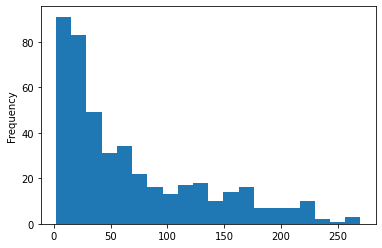

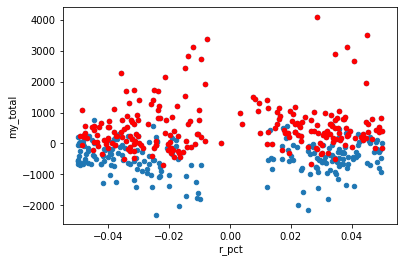

In [5]:
_entry_table['sig_len'] = (_entry_table.exit_signal_date - _entry_table.entry)
_entry_table['sig_len'].plot.hist(bins=20)

ax = _entry_table.plot.scatter(x='r_pct', y='my_total')
_entries_partial_exit = _entry_table.loc[_entry_table.partial_exit_date.notna()].copy()

_entries_partial_exit.plot.scatter(x='r_pct', y='my_total', color='r', ax=ax)

len(_entries_partial_exit) / len(_entry_table)


In [6]:
_entry_table.loc[abs(_entry_table.r_pct) > 0.2]

,entry,en_px,st_px,dir,trail_stop,fixed_stop,fixed_stop_price,r_pct,target_price,partial_exit_date,...,partial_exit,risk,shares,partial_profit,rem_profit,partial_total,no_partial_total,my_total,total,sig_len


<AxesSubplot:ylabel='Frequency'>

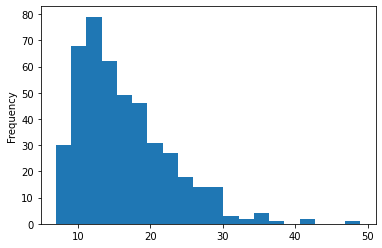

In [7]:
_entry_table['entry_lag'] = (_entry_table.entry - _entry_table.trail_stop)
_entry_table['entry_v'] = _entry_table.r_pct / _entry_table.entry_lag
# _entry_table.entry_lag.plot.hist(bins=20)
_entry_table['entry_v'] = abs(_entry_table.entry_v)
_entry_table.entry_lag.plot.hist(bins=20)

<AxesSubplot:xlabel='entry_v', ylabel='my_total'>

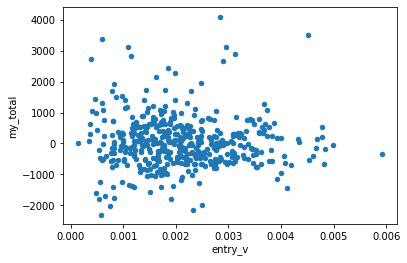

In [8]:
_entry_table.plot.scatter(x='entry_v', y='my_total')

In [9]:

def get_peaks_between_entry_discovery(ent_table, pks):
    rows = []
    for idx, row_data in ent_table.iterrows():
        peak_query = (
                (pks.start > row_data.trail_stop) &
                (pks.start < row_data.entry) &
                (pks.type != row_data.dir) &
                (pks.symbol == row_data.symbol)
        )
        peaks = pks.loc[peak_query]
        prior_peaks_q = peak_query.shift(-1)
        prior_peaks_q.iat[-1] = False
        prior_peaks = pks.loc[prior_peaks_q]

        if not peaks.empty:
            _row = row_data.copy()
            _row['op_sw_dt'] = peaks.end.iat[0]
            rows.append(_row)

    return pd.DataFrame(rows)


def get_prior_peak(ent_table, pks, lvl=4):
    rows = []
    use_lvl = lvl
    for idx, row_data in ent_table.iterrows():
        use_lvl = lvl
        while use_lvl > 0:
            pks_cpy = pks.loc[pks.lvl == use_lvl].copy()
            peak_query = (
                (pks_cpy.start < row_data.entry) &
                (((pks_cpy.st_px - row_data.en_px) * row_data.dir) > 0) &
                (pks_cpy.type != row_data.dir) &
                (pks_cpy.symbol == row_data.symbol)
            )
            prior_peaks = pks_cpy.loc[peak_query]
            if not prior_peaks.empty:
                break
            use_lvl -= 1


        if not prior_peaks.empty:
            prior_val = prior_peaks.st_px.iloc[-1]
        else:
            prior_val = (
                (
                    pks_cpy.loc[
                         (pks_cpy.symbol == row_data.symbol) &
                         (pks_cpy.type != row_data.dir), 'st_px'
                    ] * row_data.dir
                ).max() * row_data.dir
            )
        dist_diff = ((row_data.target_price - prior_val)/prior_val) * row_data.dir
        if dist_diff > 0:
            rc = row_data.copy()
            rc['dist_diff'] = dist_diff
            rows.append(rc)

    return pd.DataFrame(rows)

lvl_peaks = _peak_table.loc[(_peak_table.lvl == 4)].copy()
# rws = get_peaks_between_entry_discovery(_entry_table, lvl_peaks)
# print(len(rws.loc[rws.op_sw_dt < rws.entry]) / len(rws))
# rws.loc[rws.op_sw_dt > rws.entry, 'my_total'].plot.hist(bins=20)

rws = get_prior_peak(_entry_table, lvl_peaks)
# rws.my_total.plot.hist(bins=50)

<AxesSubplot:xlabel='dist_diff', ylabel='my_total'>

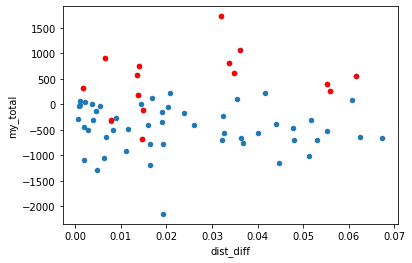

In [10]:
ax = rws.plot.scatter(x='dist_diff', y='my_total')
rws.loc[rws.partial_exit_date.notna()].plot.scatter(x='dist_diff', y='my_total', ax=ax, color='red')